# Monthly Projections

The purpose of this notebook is to forecast monthly collections of food waste.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [12]:
import sys
sys.path.append('C:\\Users\\kmkei\\Documents\\Projects\\food_waste\\src')
import read_data

# Read and Explore Data

In [16]:
# read in collections data
coll_df = read_data.read_collections_data()

In [17]:
# since collection frequency is irregular at day or week level, let's aggregate to monthly
coll_df['mth'] = coll_df['collection_date'].dt.to_period('M').dt.to_timestamp()
coll_df2 = coll_df.groupby(['stop_name', 'mth'], as_index=False).agg({'food_waste_collected':'sum'})

In [18]:
# check that we have complete series per location name
coll_df2.groupby("stop_name").agg({'mth':['min', 'max', 'nunique']})

# correct for Citizen's Convenience Center
# correct for Mills Park

mth                   
                                    min        max nunique
stop_name                                                 
Citizen's Convenience Center 2022-02-01 2024-12-01      35
Mills Park                   2024-01-01 2024-12-01      12

In [19]:
# distribution of food collected
coll_df2.describe()

,mth,food_waste_collected
count,47,47.000000
mean,2023-09-29 10:12:45.957446912,7886.363830
min,2022-02-01 00:00:00,0.000000
25%,2023-01-16 12:00:00,6239.500000
50%,2024-01-01 00:00:00,7813.400000
75%,2024-06-16 00:00:00,9764.600000
max,2024-12-01 00:00:00,12905.000000
std,NaN,2706.453092


The history for this data is pretty limited, especially for Mills Park. Because of this, it might be difficult to discern regular patterns (e.g., seasonality). Therefore, I think forecasting analyses should be kept simple so as not to overfit.

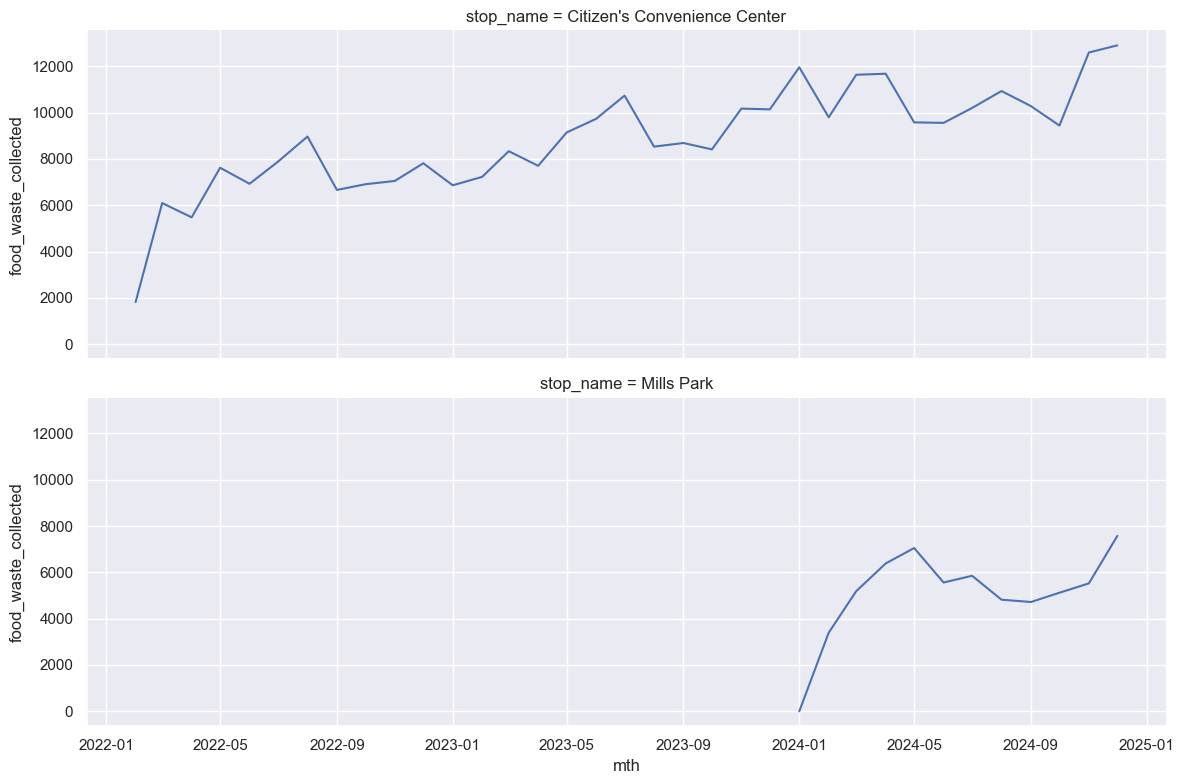

In [22]:
# visualize monthly total collections
g = sns.FacetGrid(coll_df2, col="stop_name", col_wrap=1, height=4, aspect=3)
g.map_dataframe(sns.lineplot, x="mth", y="food_waste_collected")

## Forecasting

I'm going to start with "Citizen's Convenience Center" then come back to Mills Park. Given the extremely limited history for Mills Park, I think that one might require a different approach (e.g., simple heuristic, could possibly assume similar "start up" patterns as the other location, etc.).

I think forecasting collections data could be useful for a few reasons:

1. If employees know how much waste they can expect, they can more properly prepare and maintain the locations. For example, perhaps extra bins are needed or more frequent collections.
2. Stakeholders may use forecasts to decide if additional collection locations would be fruitful. If demand is increasing significantly at the existing locations, I think it's reasonable to think that there is good demand for this service and adding locations could be helpful.
    * NB: there are many other factors that should be considered when deciding if an additional location would be helpful. For example, perhaps the propensity for collecting food waste is particularly high at these two locations, but it wouldn't be as high at prospective locations, so it's misleading to think the current demand would transfer over. Also, how much does it cost to create and maintain a distinct collection location? Perhaps it's more cost effective to keep fewer locations, but increase their respective capacity. Without having access to business SMEs, these types of questions cannot be answered at this time.
3. At some point with enough demand (and hopefully general waste reduction), it might be worth considering if instead of drop-off locations, the city could pick up food waste from citizens (along with general waste and recycling). 
    * Similar cautions as #2 should be considered for this one, for example, what's the cost-benefit analysis? what threshold of food waste demand makes the costs of this decision worth it?

### Split Data

In [24]:
# filter down to just Citizen's Convenience Center
abt = coll_df2[coll_df2['stop_name'] == "Citizen's Convenience Center"]

I'm going to forecast 6 months into the future. The forecast horizon depends on the business use-case and normally I would consult business stakeholders to know what horizon makes sense for their purposes. However, since I do not have access to an SME, I'm going to pick 6 months. I think it's a reasonable horizon given some of the possible use cases I outlined above.

In [25]:
# set up training and hold-out set
train = abt[abt['mth'] < pd.to_datetime("2024-07-01")]
test = abt[abt['mth'] >= pd.to_datetime("2024-07-01")]

### Prep

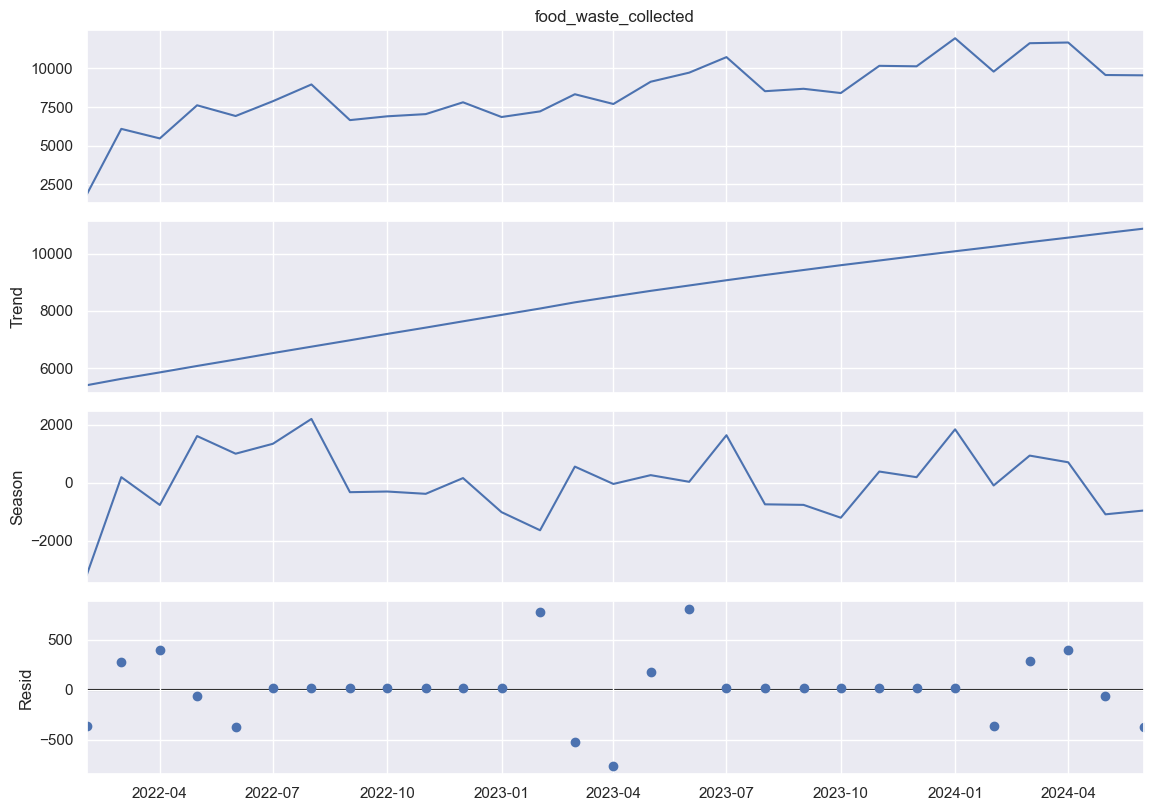

In [42]:
# visualize time series decomposition: https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
train_ts = train.food_waste_collected
train_ts.index = pd.date_range("2022-02-01", periods=train.shape[0], freq="MS")

stl = STL(train_ts, seasonal=13)
res = stl.fit()
fig = res.plot()

I think there's a gradual trend, but not a strong seasonal component

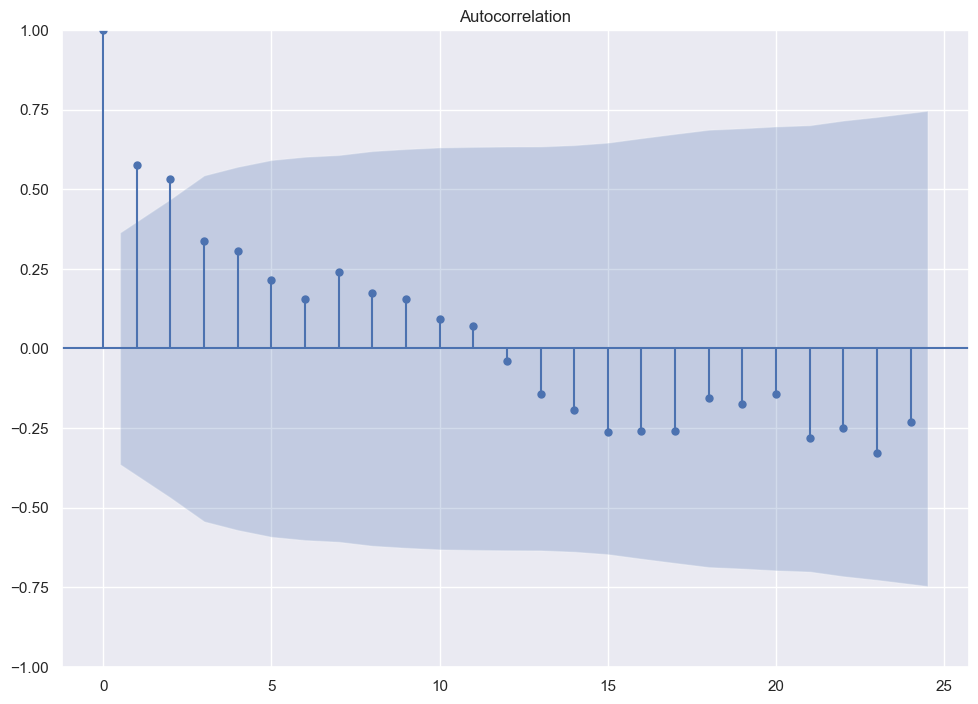

In [44]:
# visualize acf plot
sm.graphics.tsa.plot_acf(train_ts, lags=24)
plt.show()

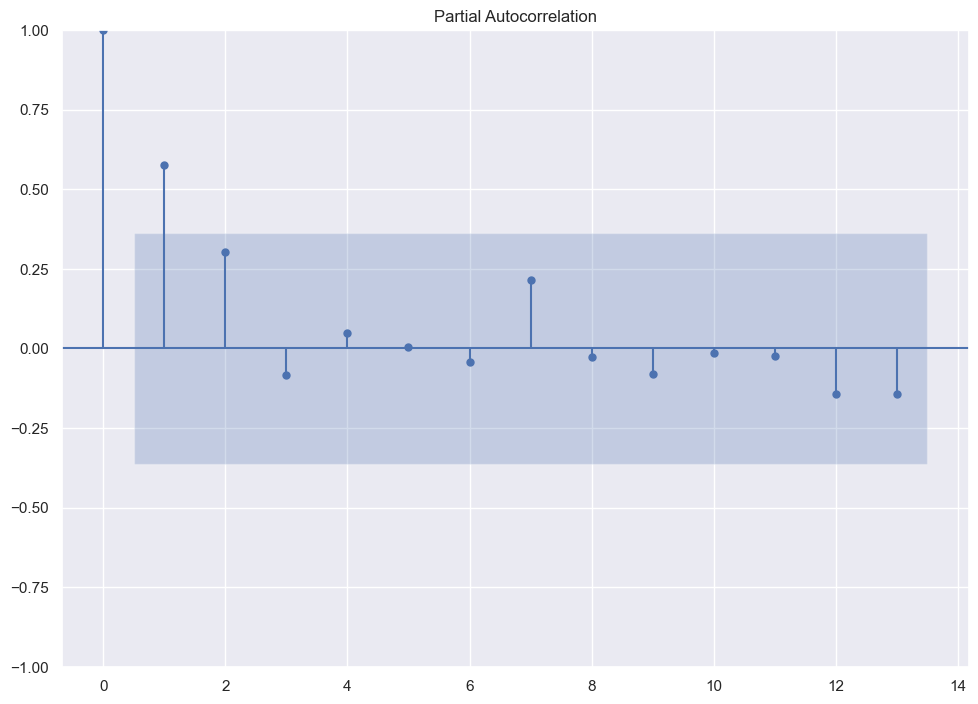

In [46]:
# visualize pacf plot
sm.graphics.tsa.plot_pacf(train_ts, lags=13)
plt.show()

From these plots, I think an AR1 model might work well.

### Exponential Smoothing

Again, due to the limited history (and lack of exogenous data at this time), I'd like to keep the methods used simple to avoid overfitting. So I'll start with Holt's method.

I'm going to do 2-fold cross-validation with test folds of 6 months. I'm pretty sure statsmodels doesn't have a built-in cross-validation functionality, so I'll have to loop through the process manually.

In [104]:
cutoffs = ["2023-07-01", "2024-01-01"]

results = []
for c in cutoffs:

    # generate folds
    trn = train[train['mth'] < pd.to_datetime(c)]
    tst = train[(train['mth'] >= pd.to_datetime(c)) & (train['mth'] < (pd.to_datetime(c) + pd.DateOffset(months=6)))]
    print(f"Train set: {trn.mth.min()} to {trn.mth.max()}")
    print(f"Test set: {tst.mth.min()} to {tst.mth.max()}")

    # fit model
    trn_ts = trn.food_waste_collected
    trn_ts.index = pd.date_range(trn.mth.min(), trn.mth.max(), freq="MS")
    fit1 = Holt(trn_ts).fit()
    fit2 = Holt(trn_ts, damped_trend=True).fit()

    # generate forecast
    fcast1 = fit1.forecast(6)
    fcast2 = fit2.forecast(6)
    tst = tst.merge(pd.DataFrame(fcast1, columns=["holt_fcst"]), left_on="mth", right_index=True).merge(pd.DataFrame(fcast2, columns=["holt_damp_fcst"]), left_on="mth", right_index=True)
    tst = tst.assign(cutoff=c)
    results.append(tst)
results = pd.concat(results)

Train set: 2022-02-01 00:00:00 to 2023-06-01 00:00:00
Test set: 2023-07-01 00:00:00 to 2023-12-01 00:00:00
Train set: 2022-02-01 00:00:00 to 2023-12-01 00:00:00
Test set: 2024-01-01 00:00:00 to 2024-06-01 00:00:00


c:\Users\kmkei\Documents\Projects\food_waste\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\kmkei\Documents\Projects\food_waste\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [105]:
# visualize the forecasts
results2 = train.merge(results[['cutoff']].drop_duplicates(), how="cross").merge(results.drop(columns=['food_waste_collected']), on=['stop_name', 'mth', 'cutoff'], how="left")
results3 = results2.melt(id_vars=['stop_name', 'mth', 'cutoff'])

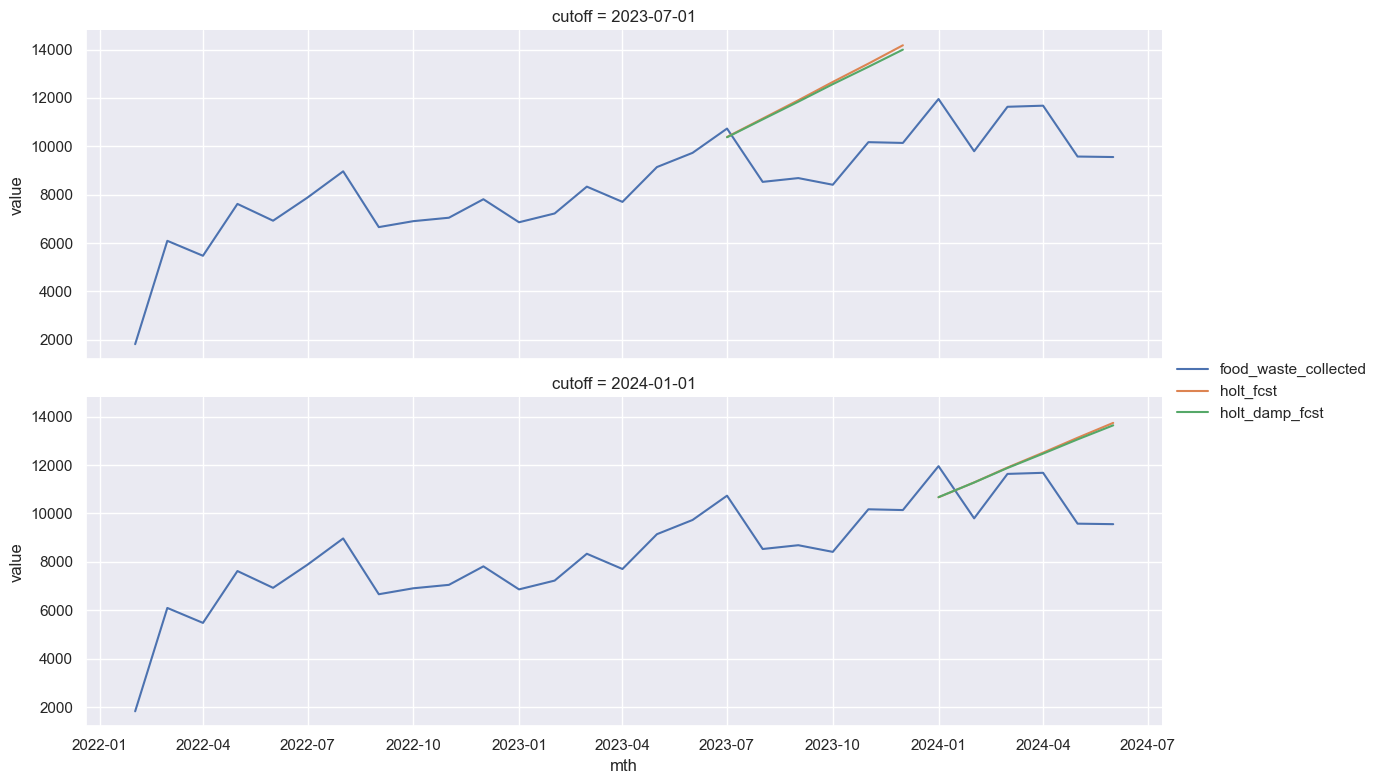

In [106]:
g = sns.FacetGrid(results3, col="cutoff", col_wrap=1, height=4, aspect=3)
g.map_dataframe(sns.lineplot, x="mth", y="value", hue="variable")
g.add_legend()

The trend being projected is pretty significant and, obviously, not reflective of the actual values. I think a damped trend component might perform better.

Making the trend "damped" doesn't seem to have helped the forecast very much.

### ARIMA

Based on the ACF and PACF plots, I'm first going to try an AR1 model.

In [97]:
cutoffs = ["2023-07-01", "2024-01-01"]

results = []
for c in cutoffs:

    # generate folds
    trn = train[train['mth'] < pd.to_datetime(c)]
    tst = train[(train['mth'] >= pd.to_datetime(c)) & (train['mth'] < (pd.to_datetime(c) + pd.DateOffset(months=6)))]
    print(f"Train set: {trn.mth.min()} to {trn.mth.max()}")
    print(f"Test set: {tst.mth.min()} to {tst.mth.max()}")

    # fit model
    trn_ts = trn.food_waste_collected
    trn_ts.index = pd.date_range(trn.mth.min(), trn.mth.max(), freq="MS")
    mod = sm.tsa.statespace.SARIMAX(trn_ts, order=(1, 1, 0))
    res = mod.fit()

    # generate forecast
    fcast = res.forecast(6)
    tst = tst.merge(pd.DataFrame(fcast).rename(columns={'predicted_mean':'fcst'}), left_on="mth", right_index=True)
    tst = tst.assign(cutoff=c)
    results.append(tst)
results = pd.concat(results)

Train set: 2022-02-01 00:00:00 to 2023-06-01 00:00:00
Test set: 2023-07-01 00:00:00 to 2023-12-01 00:00:00
Train set: 2022-02-01 00:00:00 to 2023-12-01 00:00:00
Test set: 2024-01-01 00:00:00 to 2024-06-01 00:00:00


In [98]:
# visualize the forecasts
results2 = train.merge(results[['cutoff']].drop_duplicates(), how="cross").merge(results.drop(columns=['food_waste_collected']), on=['stop_name', 'mth', 'cutoff'], how="left")
results3 = results2.melt(id_vars=['stop_name', 'mth', 'cutoff'])

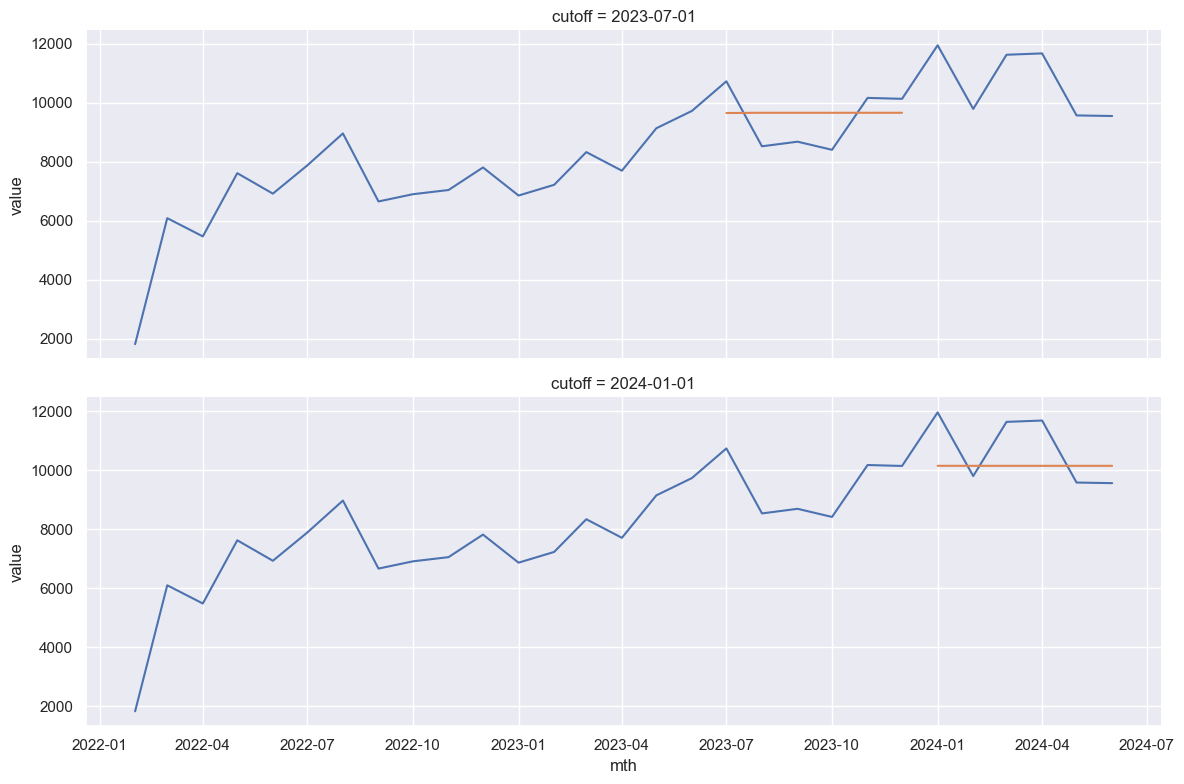

In [99]:
g = sns.FacetGrid(results3, col="cutoff", col_wrap=1, height=4, aspect=3)
g.map_dataframe(sns.lineplot, x="mth", y="value", hue="variable")

This ARIMA model doesn't project as aggressive of a trend; it's closer to predicting a rolling average, which is probably more accurate on average, but perhaps less helpful.

## Next Steps

* calculate error metrics
* test other model algorithms and configurations